<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# NLmod examples  

This example notebook shows a basic example of a model created with the `nlmod` package. The `nlmod` package contains functions to create modflow models anywhere in the Netherlands.

### Table of contents
1. [Create model](#create)
2. [Run model](#run)
3. [Visualise](#Visualise)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd

import nlmod

print(f'nlmod version: {nlmod.__version__}')

nlmod version: 0.0.2b


### 1. Create model<a name="create"></a>

With the code below we create a modflow model named 'IJmuiden'. This model has the following properties :
- an extent that covers part of the Northsea, Noordzeekanaal and the small port city IJmuiden.
- a structured grid based on the subsurface models [Regis](https://www.dinoloket.nl/regis-ii-het-hydrogeologische-model) and [Geotop](https://www.dinoloket.nl/detaillering-van-de-bovenste-lagen-met-geotop). The Regis layers that are not present within the extent are removed. In this case we use b'MSz1' as the bottom layer of the model. Use `nlmod.regis.get_layer_names()` to get all the layer names of Regis. All Regis layers below this layer are not used in the model. Geotop is used to replace the holoceen layer in Regis because there is no kh or kv defined for the holoceen in Regis. Part of the model is in the North sea. Regis and Geotop have no data there. Therefore the Regis and Geotop layers are extrapolated from the shore and the seabed is added using bathymetry data from [Jarkus](https://www.openearth.nl/rws-bathymetry/2018.html).
- starting heads of 1 in every cell.
- the model is a steady state model of a single time step.
- big surface water bodies (Northsea, IJsselmeer, Markermeer, Noordzeekanaal) within the extent are added as a general head boundary. The surface water bodies are obtained from a [shapefile](..\data\opp_water.shp).
- surface drainage is added using [ahn](https://www.ahn.nl) data and a default conductance of $1000 m^2/d$
- recharge is not available at the moment because of technical issues with the KNMI api ~~recharge is added using data from the [knmi](https://www.knmi.nl/nederland-nu/klimatologie/daggegevens) using the following steps:~~
    1. ~~Check for each cell which KNMI weather and/or rainfall station is closest.~~
    2. ~~Download the data for the stations found in 1. for the model period. For a steady state stress period the average precipitation and evaporation of 8 years before the stress period time is used.~~
    3. ~~Combine precipitation and evaporation data from step 2 to create a recharge time series for each cell~~
    4. ~~Add the timeseries to the model dataset and create the recharge package.~~
- constant head boundaries are added to the model edges in every layer. The starting head is used as constant head.

In [2]:
# model settings
model_ws = 'model1'
model_name = 'IJmuiden'
use_cache = True
extent = [95000., 105000., 494000., 500000.]
delr = 100.
delc = 100.
steady_state = True
verbose = True
start_time = '2015-1-1'
gridtype = 'structured'
use_regis = True
regis_botm_layer = b'MSz1'
use_geotop = True
add_northsea = True
starting_head = 1.0

In [3]:
# Model directories
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)

# create model time dataset
model_ds = nlmod.mdims.get_model_ds_time(model_name, model_ws, start_time,
                                         steady_state)


extent, nrow, ncol = nlmod.read.regis.fit_extent_to_regis(extent,
                                                          delr,
                                                          delc, verbose=verbose)

# layer model
layer_model = nlmod.read.regis.get_layer_models(extent, delr, delc,
                                                use_regis=use_regis,
                                                regis_botm_layer=regis_botm_layer,
                                                use_geotop=use_geotop,
                                                cachedir=cachedir,
                                                fname_netcdf='combined_layer_ds.nc',
                                                use_cache=use_cache,
                                                verbose=verbose)

# create modflow packages
sim, gwf = nlmod.mfpackages.sim_tdis_gwf_ims_from_model_ds(model_ds,
                                                           verbose=verbose)

redefining current extent: [95000.0, 105000.0, 494000.0, 500000.0], fit to regis raster
new extent is [95000.0, 105000.0, 494000.0, 500000.0] model has 60 rows and 100 columns
found cached combined_layer_ds.nc, loading cached dataset
delr of current grid is the same as cached grid
delc of current grid is the same as cached grid
extent of current grid differs from cached grid
creating and caching dataset combined_layer_ds.nc

creating modflow SIM, TDIS, GWF and IMS


In [4]:
# update model_ds from layer model
model_ds = nlmod.mdims.update_model_ds_from_ml_layer_ds(model_ds,
                                                        layer_model,
                                                        keep_vars=['x', 'y'],
                                                        gridtype=gridtype,
                                                        add_northsea=add_northsea,
                                                        use_cache=use_cache,
                                                        verbose=verbose)

# Create discretization
nlmod.mfpackages.dis_from_model_ds(model_ds, gwf)

# create node property flow
nlmod.mfpackages.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
nlmod.mfpackages.ic_from_model_ds(model_ds, gwf, starting_head=starting_head)

# Create the output control package
nlmod.mfpackages.oc_from_model_ds(model_ds, gwf);

add kh and kv from model layer dataset to modflow model
layer 0 has a kh
layer 1 has a kh
layer 2 has a kh
layer 3 has a kh
layer 4 has a kh
layer 5 has a kh
layer 6 has a kh
layer 7 has a kh
layer 8 has a kh
layer 9 has a kh
layer 10 has a kh
layer 11 has a kh
layer 12 has a kh
layer 13 has a kh
layer 14 has a kv
layer 15 has a kh
layer 16 has a kv
layer 17 has a kh
layer 18 has a kh
layer 19 has a kv
layer 20 has a kh
layer 21 has a kv
layer 22 has a kh
layer 23 has a kh
layer 24 has a kh
layer 25 has a kh
layer 26 has a kv
layer 27 has a kh
layer 28 has a kh
layer 29 has a kv
layer 30 has a kh
layer 31 has a kh
layer 32 has a kh
layer 33 has a kv
layer 34 has a kh
layer 35 has a kv
layer 36 has a kh
layer 37 has a kh
layer 38 has a kh
layer 39 has a kh
layer 0 has a kv
layer 1 has a kv
layer 2 has a kv
layer 3 has a kv
layer 4 has a kv
layer 5 has a kv
layer 6 has a kv
layer 7 has a kv
layer 8 has a kv
layer 9 has a kv
layer 10 has a kv
layer 11 has a kh
layer 12 has a kh
layer 13 h

In [5]:
gdf = nlmod.mfpackages.surface_water.get_gdf_surface_water(model_ds)

In [6]:
fname = os.path.join(nlmod.nlmod_datadir, r'opp_water.shp')
gdf_swater = gpd.read_file(fname)

In [7]:
# voeg grote oppervlaktewaterlichamen toe
da_name = 'surface_water'
model_ds = nlmod.mfpackages.surface_water.get_general_head_boundary(model_ds,
                                                                    gwf.modelgrid,
                                                                    da_name,
                                                                    cachedir=cachedir,
                                                                    use_cache=use_cache,
                                                                    verbose=verbose)
ghb = nlmod.mfpackages.ghb_from_model_ds(model_ds, gwf, da_name)

# surface level drain
model_ds = nlmod.read.ahn.get_ahn_dataset(model_ds, use_cache=use_cache,
                                          cachedir=cachedir, verbose=verbose)

drn = nlmod.mfpackages.surface_drain_from_model_ds(model_ds, gwf)


# add constant head cells at model boundaries
chd = nlmod.mfpackages.chd_at_model_edge_from_model_ds(
    model_ds, gwf, head='starting_head')

found cached ghb_model_ds.nc, loading cached dataset
cached data grid differs from current model
creating and caching dataset ghb_model_ds.nc

found cached ahn_model_ds.nc, loading cached dataset
cached data grid differs from current model
creating and caching dataset ahn_model_ds.nc

requested ahn raster width or height bigger than 4000.0
            -> splitting extent into 3 * 2 tiles
downloading subextent [95000.0, 99000.0, 494000.0, 498000.0]
x_segment-0, y_segment-0
- download model1/cache/ahn_95000_99000_494000_498000_5000.tiff
downloading subextent [95000.0, 99000.0, 498000.0, 500000.0]
x_segment-0, y_segment-1
- download model1/cache/ahn_95000_99000_498000_500000_5000.tiff
downloading subextent [99000.0, 103000.0, 494000.0, 498000.0]
x_segment-1, y_segment-0
- download model1/cache/ahn_99000_103000_494000_498000_5000.tiff
downloading subextent [99000.0, 103000.0, 498000.0, 500000.0]
x_segment-1, y_segment-1
- download model1/cache/ahn_99000_103000_498000_500000_5000.tiff
downl

In [8]:
# add knmi recharge to the model datasets
model_ds = nlmod.read.knmi.get_recharge(model_ds,
                                        verbose=verbose,
                                        cachedir=cachedir,
                                        use_cache=use_cache)
# create recharge package
rch = nlmod.mfpackages.rch_from_model_ds(model_ds, gwf)

creating and caching dataset rch_model_ds.nc



In [9]:
# save model_ds
model_ds.to_netcdf(os.path.join(cachedir, 'full_model_ds.nc'))

A big part of the model data is stored in the variable `model_ds` which is an `xarray.Dataset`. The data is shown below.

In [10]:
model_ds

<xarray.Dataset>
Dimensions:             (layer: 40, time: 1, x: 100, y: 60)
Coordinates:
  * time                (time) datetime64[ns] 2015-01-01
  * x                   (x) float64 9.505e+04 9.515e+04 ... 1.048e+05 1.05e+05
  * y                   (y) float64 5e+05 4.998e+05 ... 4.942e+05 4.940e+05
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
Data variables: (12/17)
    time_steps          (time) int64 0
    idomain             (layer, y, x) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (y, x) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    bot                 (layer, y, x) float64 -12.66 -12.66 ... -218.2 -218.5
    top                 (y, x) float64 0.0 0.0 0.0 0.0 ... 2.29 1.49 0.5 0.37
    kh                  (layer, y, x) float64 10.0 10.0 10.0 ... 6.1 6.11 6.11
    ...                  ...
    surface_water_area  (y, x) float64 1e+04 1e+04 1e+04 1e+04 ... 0.0 0.0 0.0
    surface_water_cond  (y, x) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    surface_water_peil  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (y, x) float64 nan nan nan nan ... 1.971 nan nan 0.2378
    chd                 (layer, y, x) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    recharge            (y, x) float64 -7.5e-05 -7.5e-05 ... 0.000875 0.000875
Attributes: (12/20)
    model_name:        IJmuiden
    model_ws:          model1
    time_units:        DAYS
    start_time:        2015-01-01 00:00:00
    nper:              1
    perlen:            1.0
    ...                ...
    delc:              100.0
    nodata:            -999
    anisotropy:        10
    fill_value_kh:     1.0
    fill_value_kv:     0.1
    surface_drn_cond:  1000

### 2. Run<a name="run"></a>
The model that we've created has not been runned yet. When you want to save and run the model you can use the code below.

Note: You always have to write the modflow data to the model workspace before you can run the model. 

In [11]:
gwf.simulation.write_simulation()
gwf.simulation.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJmuiden...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package chd...
    writing package ijmuiden...
FloPy is using the following  executable to run the model: /home/david/Github/nlmod/nlmod/mfpackages/../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 20:22:48 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and

(True, [])

### 3. Visualise<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

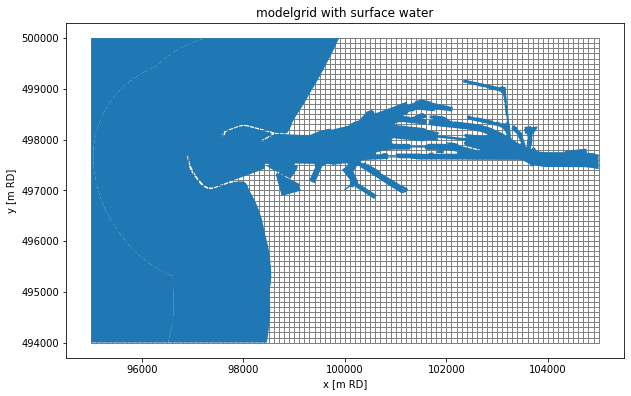

In [12]:
ax = nlmod.plots.plot_modelgrid(model_ds, gwf)
ax.figure.savefig(os.path.join(figdir, 'mgrid_swater.png'), bbox_inches='tight')

Data from a model with a structured grid can be easily visualised using the model dataset. Below some examples

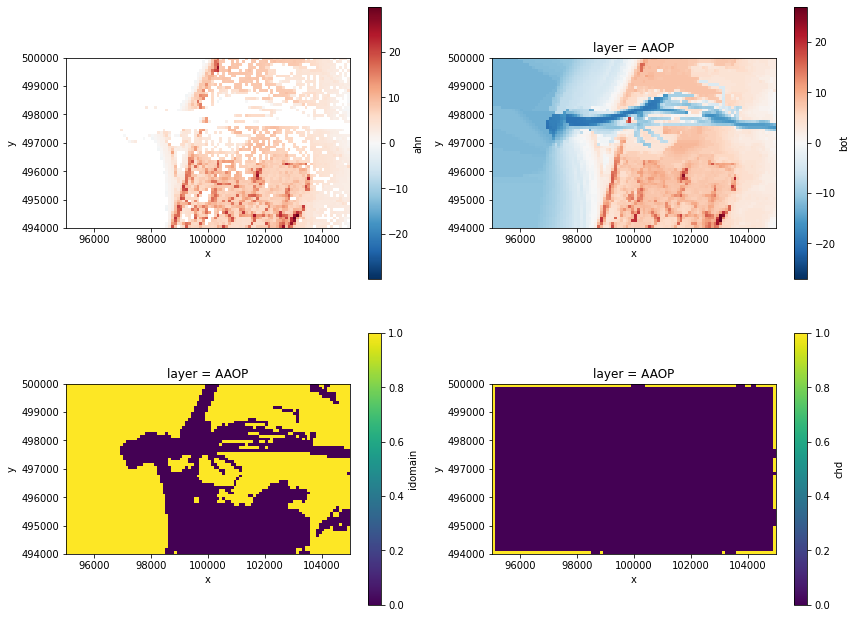

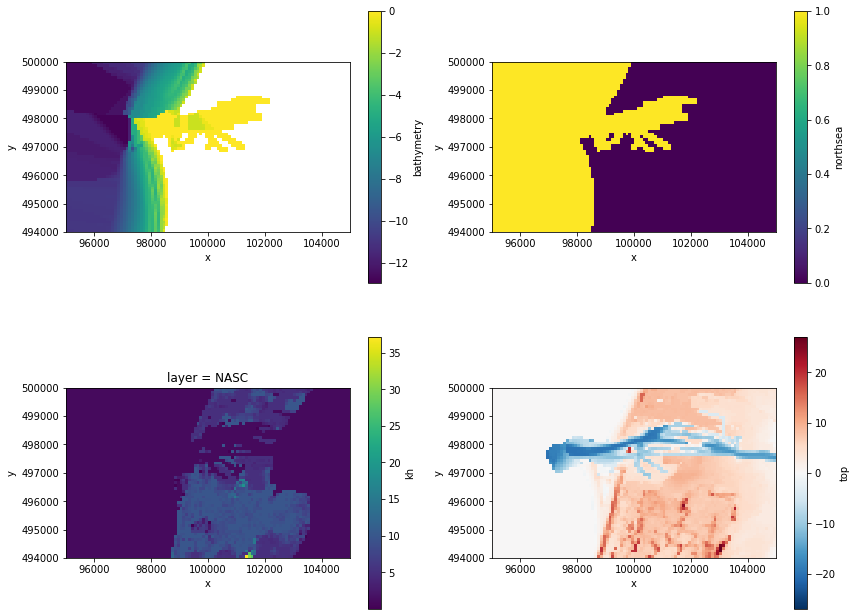

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
model_ds['ahn'].plot(ax=axes[0][0])
model_ds['bot'][0].plot(ax=axes[0][1])
model_ds['idomain'][0].plot(ax=axes[1][0])
model_ds['chd'][0].plot(ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
model_ds['bathymetry'].plot(ax=axes[0][0])
model_ds['northsea'].plot(ax=axes[0][1])
model_ds['kh'][1].plot(ax=axes[1][0])
model_ds['top'].plot(ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(figdir, 'bath_nsea_kh_top.png'), bbox_inches='tight')